<h1 align="center">Predicting High School Student Performance</h1>
<p align="center">Mary Nathalie Dela Cruz & Joshua Dela Cruz</p>

The data set contains 30 descriptors on 600+ students from two Portuguese schools. The goal is to predict G1, G2, G3, which are the 1st, 2nd, and 3rd period grades, respectively—a regression problem. The accompanying paper to this data set can be found in: http://www3.dsi.uminho.pt/pcortez/student.pdf

**Methodology:**
1. Load the Student Performance data set from the UCI Repository. For this problem, we will only deal with the Math scores.
2. Make the necessary encoding for categorical inputs. 
3. Split the data into 80% Training and 20% Testing
4. Run any AutoML procedure (either LazyPredict, Optuna, TPOT, or Auto-sklearn) to predict the G3 score using the 30 descriptors and the G1 and G2 scores as input features (32 features all in all). You may limit your search to only a few ML models, especially if you use Optuna. 
5. Report the R2 metric on all models that were tried.
6. Based on your results, perform an explainability analysis on the best model using Shapley values. 
7. Report the summary plot of the most influential descriptors, then write a discussion on your analysis.


In [33]:
from ucimlrepo import fetch_ucirepo 

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import zipfile
import urllib.request

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from lazypredict.Supervised import LazyRegressor

import shap

pd.set_option('display.max_colwidth', None)

### Exploratory Data Analysis

In [34]:
student_performance = fetch_ucirepo(id=320) 
  
# Show metadata
metadata = student_performance.metadata
for key, value in metadata.items():
    print(key, ":", value)

uci_id : 320
name : Student Performance
repository_url : https://archive.ics.uci.edu/dataset/320/student+performance
data_url : https://archive.ics.uci.edu/static/public/320/data.csv
abstract : Predict student performance in secondary education (high school). 
area : Social Science
tasks : ['Classification', 'Regression']
characteristics : ['Multivariate']
num_instances : 649
num_features : 30
feature_types : ['Integer']
demographics : ['Sex', 'Age', 'Other', 'Education Level', 'Occupation']
target_col : ['G1', 'G2', 'G3']
index_col : None
has_missing_values : no
missing_values_symbol : None
year_of_dataset_creation : 2008
last_updated : Fri Jan 05 2024
dataset_doi : 10.24432/C5TG7T
creators : ['Paulo Cortez']
intro_paper : {'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'published_in': 'Proceedings of 5th Annual Future Business Technology Conference', 'year': 2008, 'url': 'https://www.semanticscholar.org/paper/61d4

In [35]:
# Show additional information about dataset
additional_info = metadata["additional_info"]
for key, value in additional_info.items():
    print(key, ":", value)

summary : This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).
purpose : None
funded_by : None
instances_represent : None
recommended_data_splits : None
sensitive_data : None
preprocessing_description

In [36]:
# Show scientific article information
intro_paper = metadata["intro_paper"]
for key, value in intro_paper.items():
    print(key, ":", value)

title : Using data mining to predict secondary school student performance
authors : P. Cortez, A. M. G. Silva
published_in : Proceedings of 5th Annual Future Business Technology Conference
year : 2008
url : https://www.semanticscholar.org/paper/61d468d5254730bbecf822c6b60d7d6595d9889c
doi : None


In [37]:
# Show variable information
variables = student_performance.variables
display(variables)

,name,role,type,demographic,description,units,missing_values
0,school,Feature,Categorical,None,student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira),None,no
1,sex,Feature,Binary,Sex,student's sex (binary: 'F' - female or 'M' - male),None,no
2,age,Feature,Integer,Age,student's age (numeric: from 15 to 22),None,no
3,address,Feature,Categorical,None,student's home address type (binary: 'U' - urban or 'R' - rural),None,no
4,famsize,Feature,Categorical,Other,family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3),None,no
5,Pstatus,Feature,Categorical,Other,parent's cohabitation status (binary: 'T' - living together or 'A' - apart),None,no
6,Medu,Feature,Integer,Education Level,"mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)",None,no
7,Fedu,Feature,Integer,Education Level,"father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)",None,no
8,Mjob,Feature,Categorical,Occupation,"mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')",None,no
9,Fjob,Feature,Categorical,Occupation,"father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')",None,no


In [38]:
# We just want the Mathematics dataset so we download from the URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.extractall()

df = pd.read_csv('student-mat.csv', sep=";")
columns = df.columns
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [40]:
# Check for missing values
print(f"NO. OF MISSING VALLUES IN DF: {df.isnull().sum().sum()}")
# Check for duplicates
print(f"NO. OF DUPLICATES IN DF: {df.duplicated().sum()}")

NO. OF MISSING VALLUES IN DF: 0
NO. OF DUPLICATES IN DF: 0


In [41]:
# Check for unique values in each column
print("NO. OF UNIQUE VAL PER COL:")
for col in columns:
    print(f"\t{col}: {df[col].nunique()}")

NO. OF UNIQUE VAL PER COL:
	school: 2
	sex: 2
	age: 8
	address: 2
	famsize: 2
	Pstatus: 2
	Medu: 5
	Fedu: 5
	Mjob: 5
	Fjob: 5
	reason: 4
	guardian: 3
	traveltime: 4
	studytime: 4
	failures: 4
	schoolsup: 2
	famsup: 2
	paid: 2
	activities: 2
	nursery: 2
	higher: 2
	internet: 2
	romantic: 2
	famrel: 5
	freetime: 5
	goout: 5
	Dalc: 5
	Walc: 5
	health: 5
	absences: 34
	G1: 17
	G2: 17
	G3: 18


In [42]:
# Show the numerical statistics of the data
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00
mean,16.70,2.75,2.52,1.45,2.04,0.33,3.94,3.24,3.11,1.48,2.29,3.55,5.71,10.91,10.71,10.42
std,1.28,1.09,1.09,0.70,0.84,0.74,0.90,1.00,1.11,0.89,1.29,1.39,8.00,3.32,3.76,4.58
min,15.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,3.00,0.00,0.00
25%,16.00,2.00,2.00,1.00,1.00,0.00,4.00,3.00,2.00,1.00,1.00,3.00,0.00,8.00,9.00,8.00
50%,17.00,3.00,2.00,1.00,2.00,0.00,4.00,3.00,3.00,1.00,2.00,4.00,4.00,11.00,11.00,11.00
75%,18.00,4.00,3.00,2.00,2.00,0.00,5.00,4.00,4.00,2.00,3.00,5.00,8.00,13.00,13.00,14.00
max,22.00,4.00,4.00,4.00,4.00,3.00,5.00,5.00,5.00,5.00,5.00,5.00,75.00,19.00,19.00,20.00


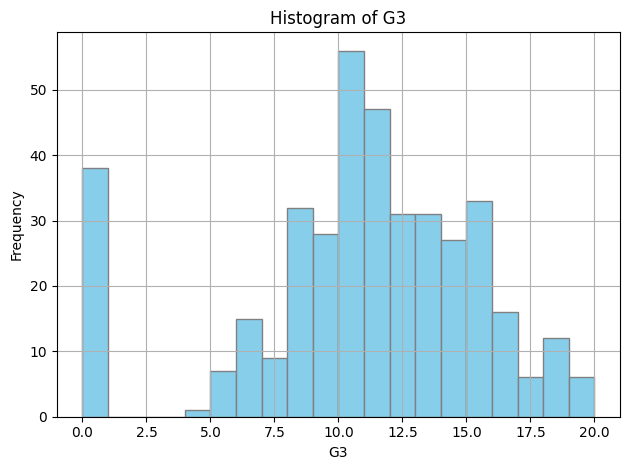

In [43]:
df['G3'].hist(bins=20, edgecolor='gray', color='skyblue')
plt.title('Histogram of G3')
plt.xlabel('G3')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [44]:
categorical_columns = df.columns[df.dtypes == 'object']
print(f"CATEGORICAL COLUMNS: \n{categorical_columns}")

CATEGORICAL COLUMNS: 
Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')


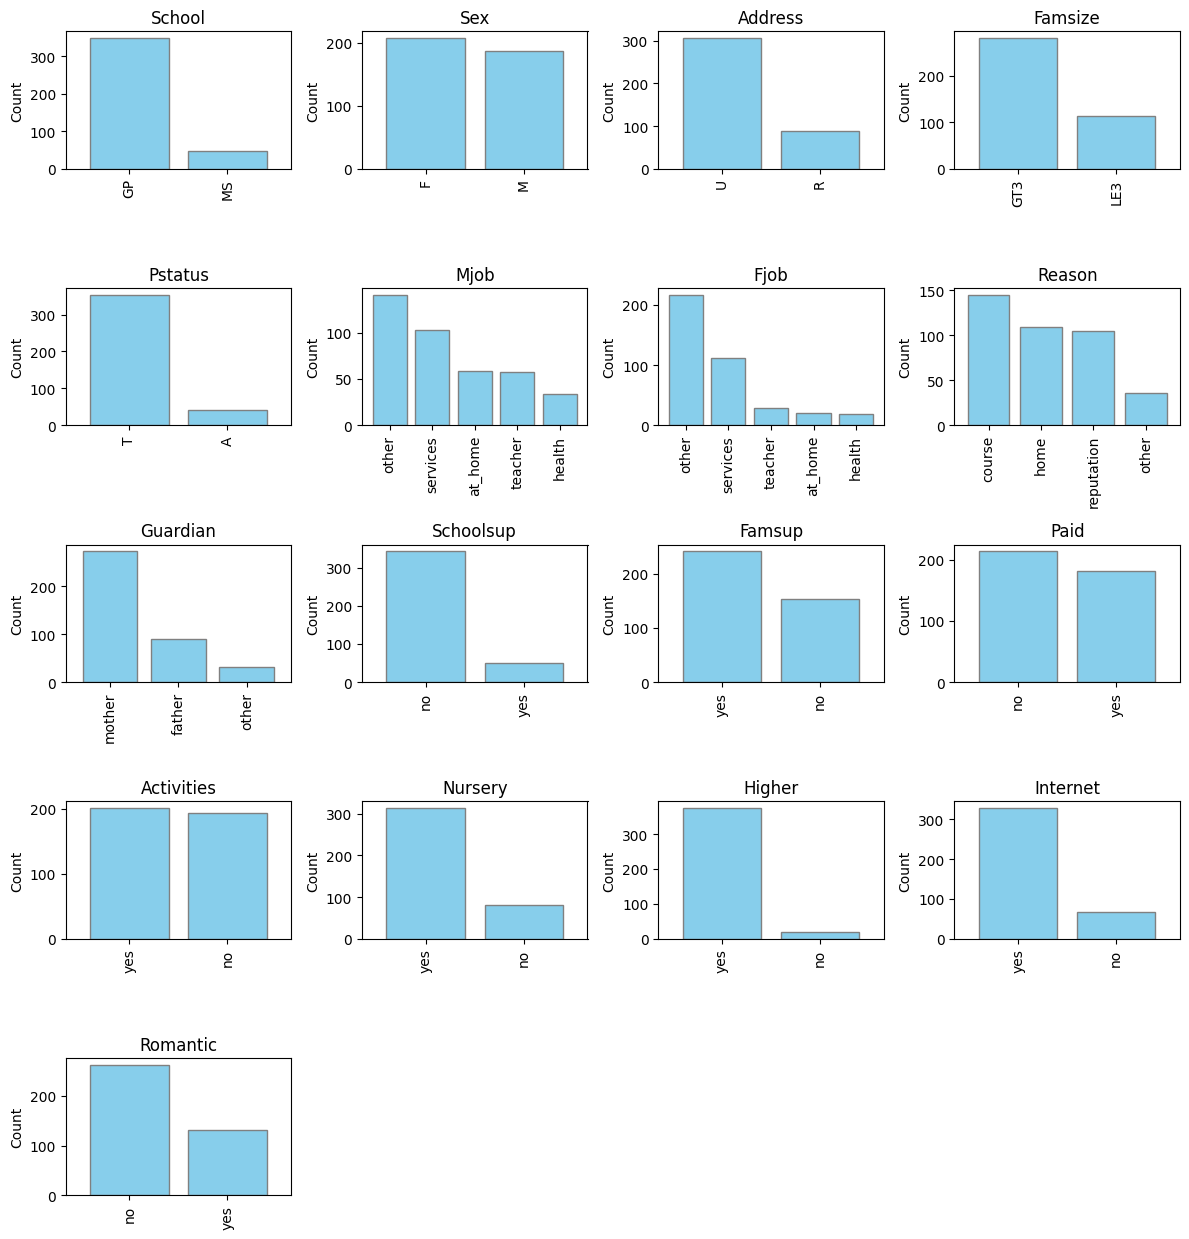

In [45]:
n = len(categorical_columns)
ncols = 4
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 2.5*nrows))

axs = axs.flatten()
for ax in axs[n:]:
    fig.delaxes(ax)

for ax, column in zip(axs, categorical_columns):
    value_counts = df[column].value_counts(ascending=False)
    value_counts.plot(kind='bar', ax=ax, width=0.8, color='skyblue', edgecolor='gray')
    ax.set_title(f'{column.capitalize()}')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

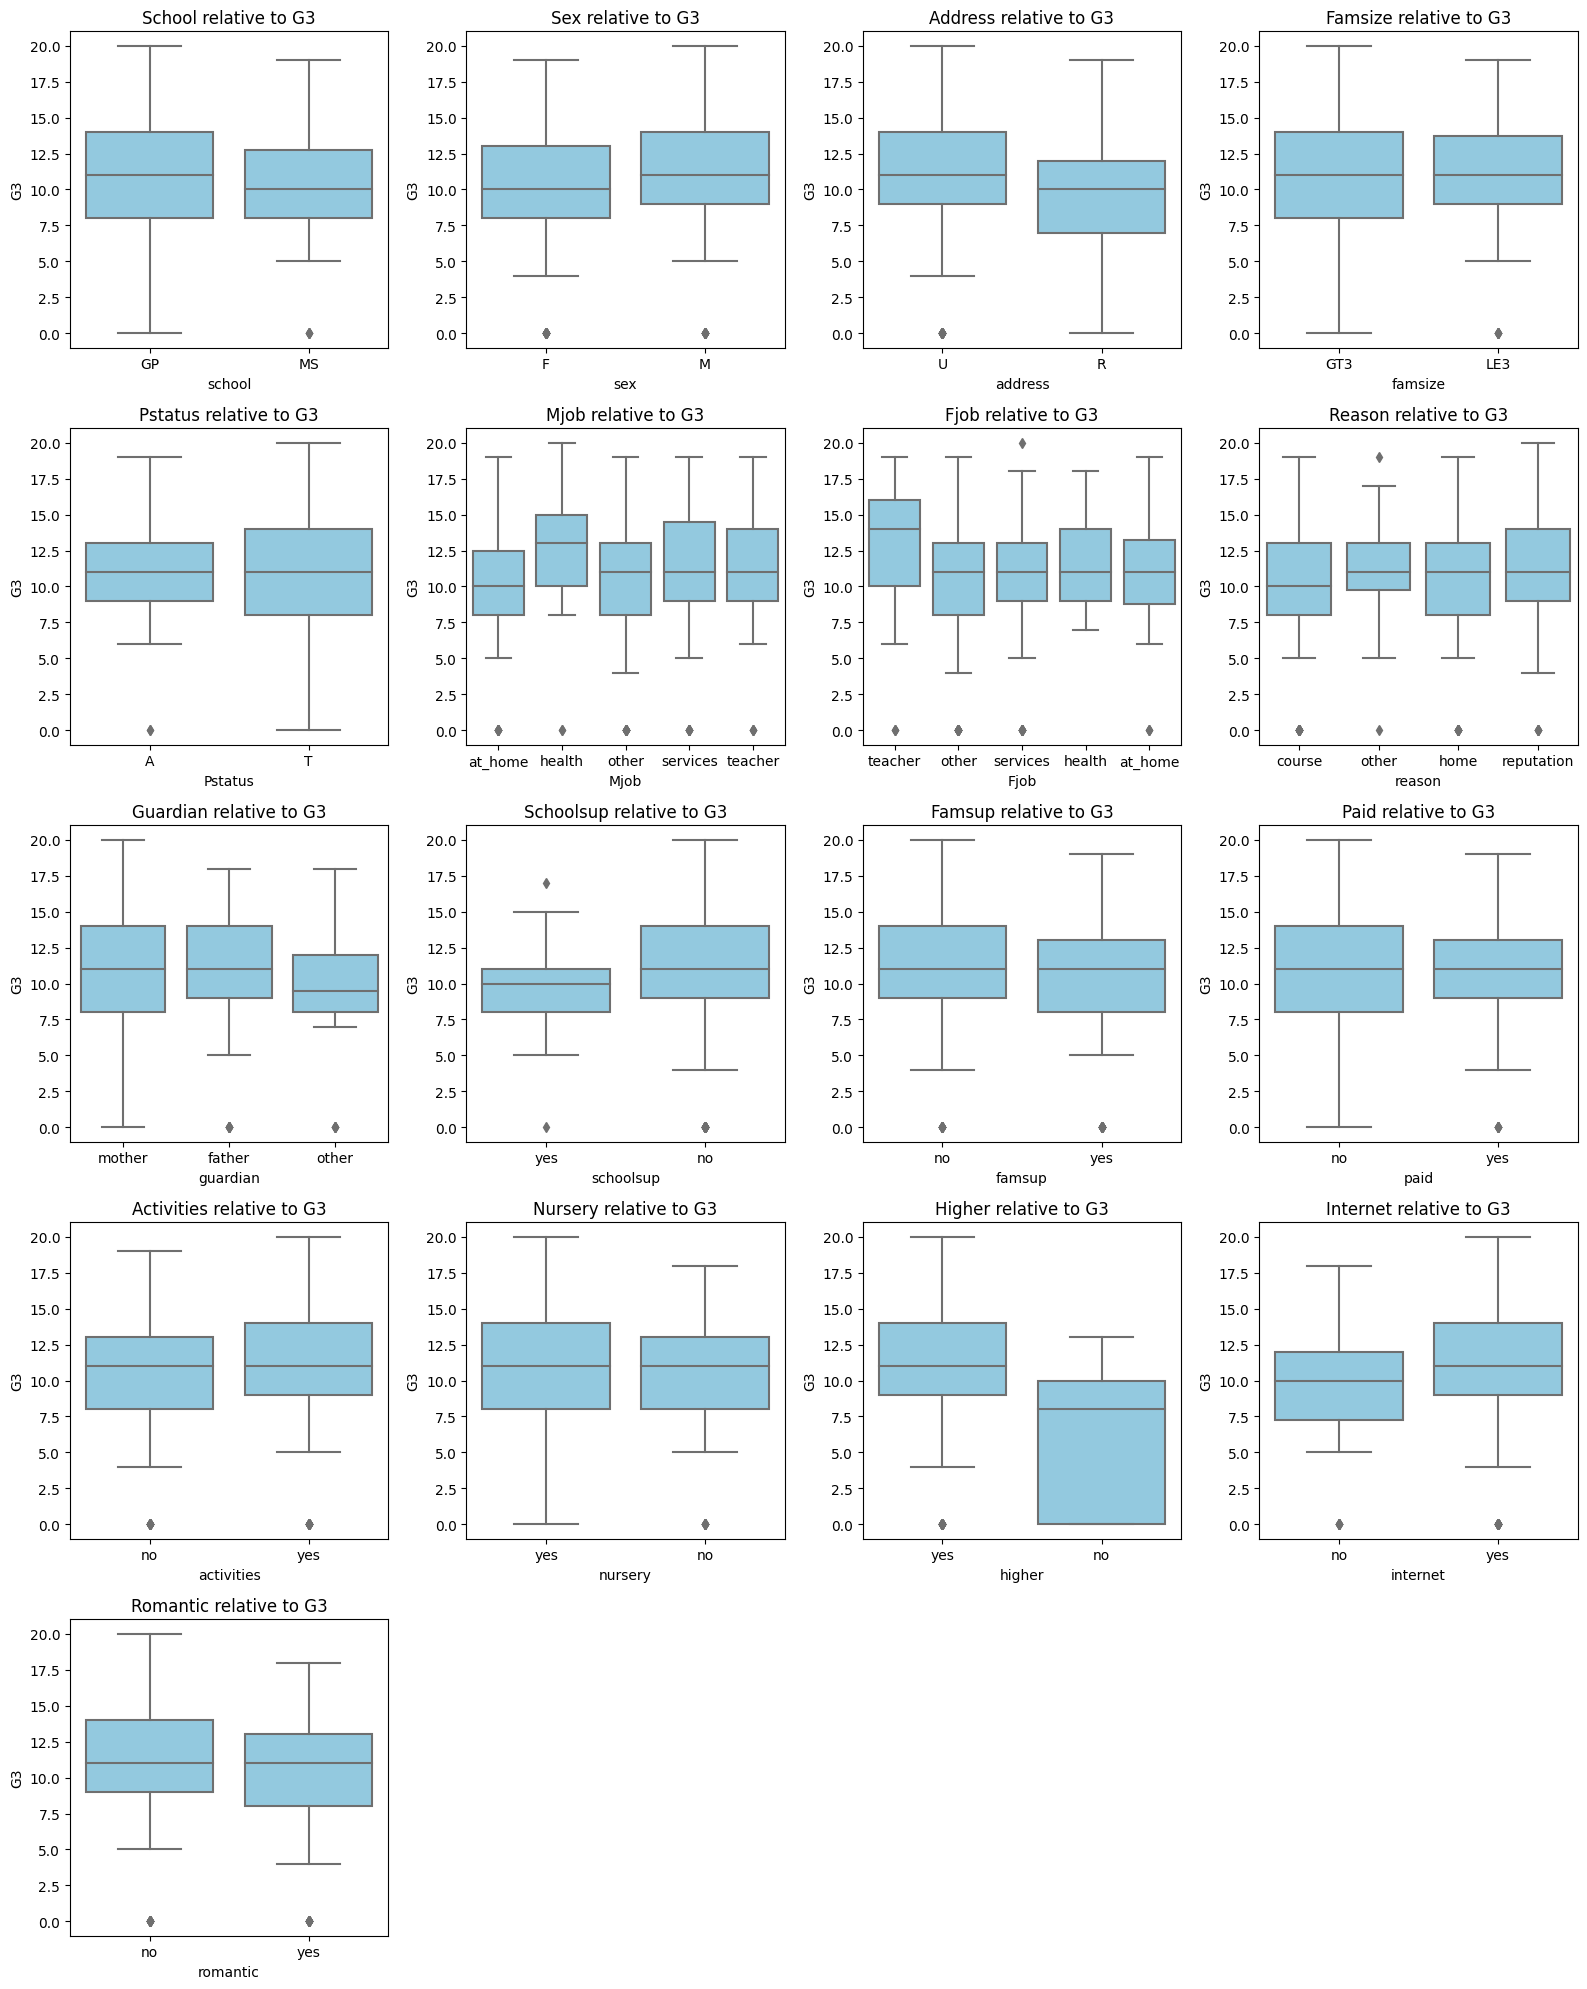

In [46]:
num_plots = len(categorical_columns)
num_cols = 4
num_rows = num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*4))

for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=column, y='G3', data=df, ax=axs[row, col], color='skyblue')
    axs[row, col].set_title(f'{column.capitalize()} relative to G3')
    

# Remove empty subplots
if num_plots % num_cols != 0:
    for col in range(num_plots % num_cols, num_cols):
        fig.delaxes(axs[num_rows-1, col])

plt.tight_layout()
plt.show()

In [47]:
numerical_columns = df.columns[df.dtypes != 'object']
numerical_columns = numerical_columns.drop('G3')
print(f"NUMERICAL COLUMNS: \n{numerical_columns}")

NUMERICAL COLUMNS: 
Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2'],
      dtype='object')


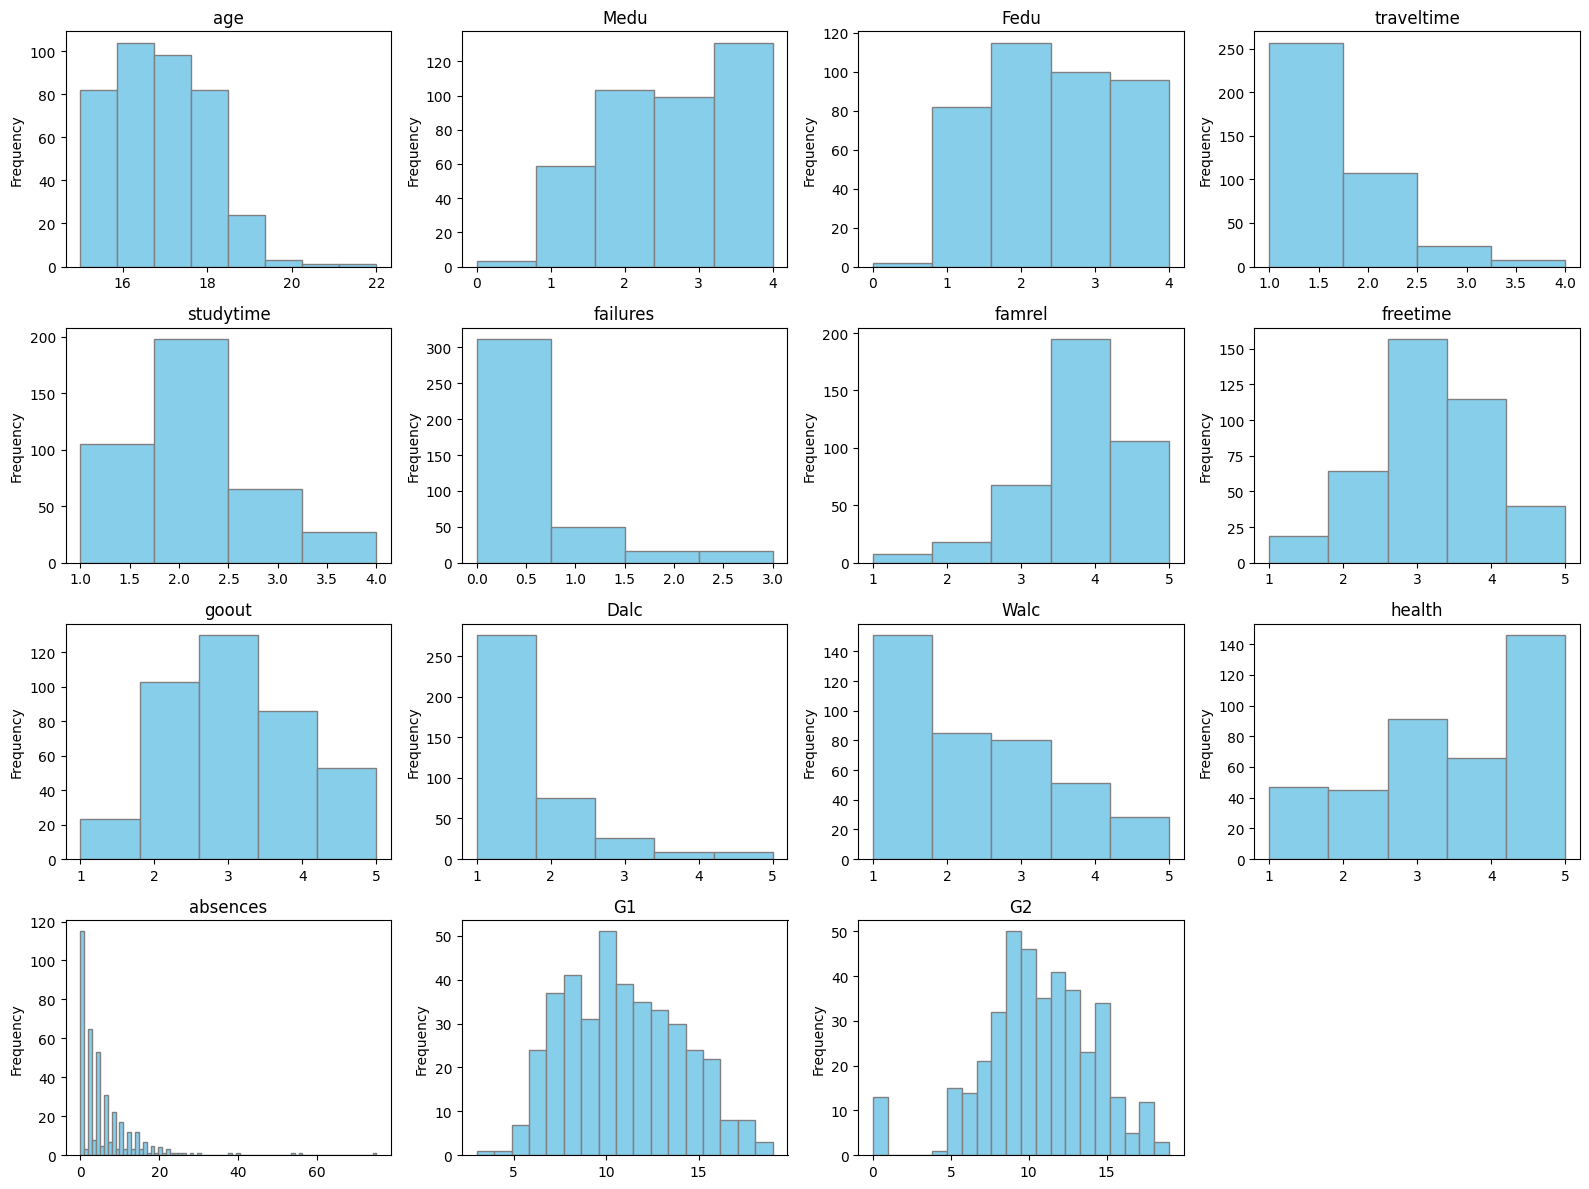

In [48]:
n = len(numerical_columns)
ncols = 4
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))

axs = axs.flatten()
for ax in axs[n:]:
    fig.delaxes(ax)

for ax, column in zip(axs, numerical_columns):
    bins = df[column].max() - df[column].min() + 1
    ax.hist(df[column], bins=int(bins), color='skyblue', edgecolor='gray')
    ax.set_title(f'{column}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

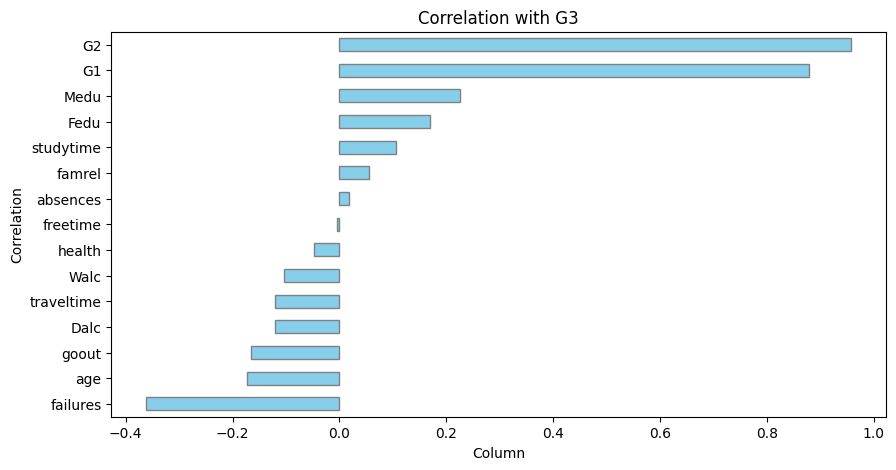

In [49]:
correlations = df[numerical_columns].corrwith(df['G3'], method='spearman')

plt.figure(figsize=(10, 5))
correlations.sort_values().plot(kind='barh', color='skyblue', edgecolor='gray')
plt.title('Correlation with G3')
plt.xlabel('Column')
plt.ylabel('Correlation')
plt.show()

### Model Development

In [50]:
X = df.drop('G3', axis=1)
y = df['G3']

print(f"Feature Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

Feature Shape: (395, 32)
Target Shape: (395,)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

print(f"X Train Shape: {X_train.shape}")
print(f"Y Train Shape: {y_train.shape}")
print(f"X Test Shape: {X_test.shape}")
print(f"Y Test Shape: {y_test.shape}")

X Train Shape: (316, 32)
Y Train Shape: (316,)
X Test Shape: (79, 32)
Y Test Shape: (79,)


In [52]:
# Encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
        ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [53]:
reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 29%|██▊       | 12/42 [00:00<00:01, 18.05it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|██████████| 42/42 [00:03<00:00, 13.03it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 31
[LightGBM] [Info] Start training from score 10.262658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [54]:
sorted_model =  models.sort_values('R-Squared', ascending=False)
best_model = sorted_model.iloc[0]
print(f"BEST MODEL: {best_model.name}")
print(best_model)
print("\nSORTED MODELS BY R-SQUARED:")
print(sorted_model)

BEST MODEL: RandomForestRegressor
Adjusted R-Squared   0.87
R-Squared            0.92
RMSE                 1.34
Time Taken           0.33
Name: RandomForestRegressor, dtype: float64

SORTED MODELS BY R-SQUARED:
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.87       0.92  1.34        0.33
LGBMRegressor                                0.86       0.92  1.35        0.03
HistGradientBoostingRegressor                0.86       0.92  1.37        0.22
GradientBoostingRegressor                    0.86       0.91  1.39        0.11
DecisionTreeRegressor                        0.85       0.91  1.41        0.01
BaggingRegressor                             0.85       0.91  1.44        0.05
XGBRegressor                                 0.84       0.91  1.45        0.07
ExtraTreesRegressor                          0.80       0.88  1.64        0.31

In [55]:
best_model_ = reg.models[best_model.name]
model = best_model_.named_steps['regressor']
best_model_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64')),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Int64Index([], dtype='int64')),
                                                 ('categorical_high',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Int64Index([], dtype='int64'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [56]:
X_column = pd.DataFrame(X_test, columns=X.columns)
explainer = shap.Explainer(model.predict, X_column)

shap_values = explainer.shap_values(X_column)
num_features = X_column.shape[1]


PermutationExplainer explainer: 80it [00:11,  1.05it/s]                        


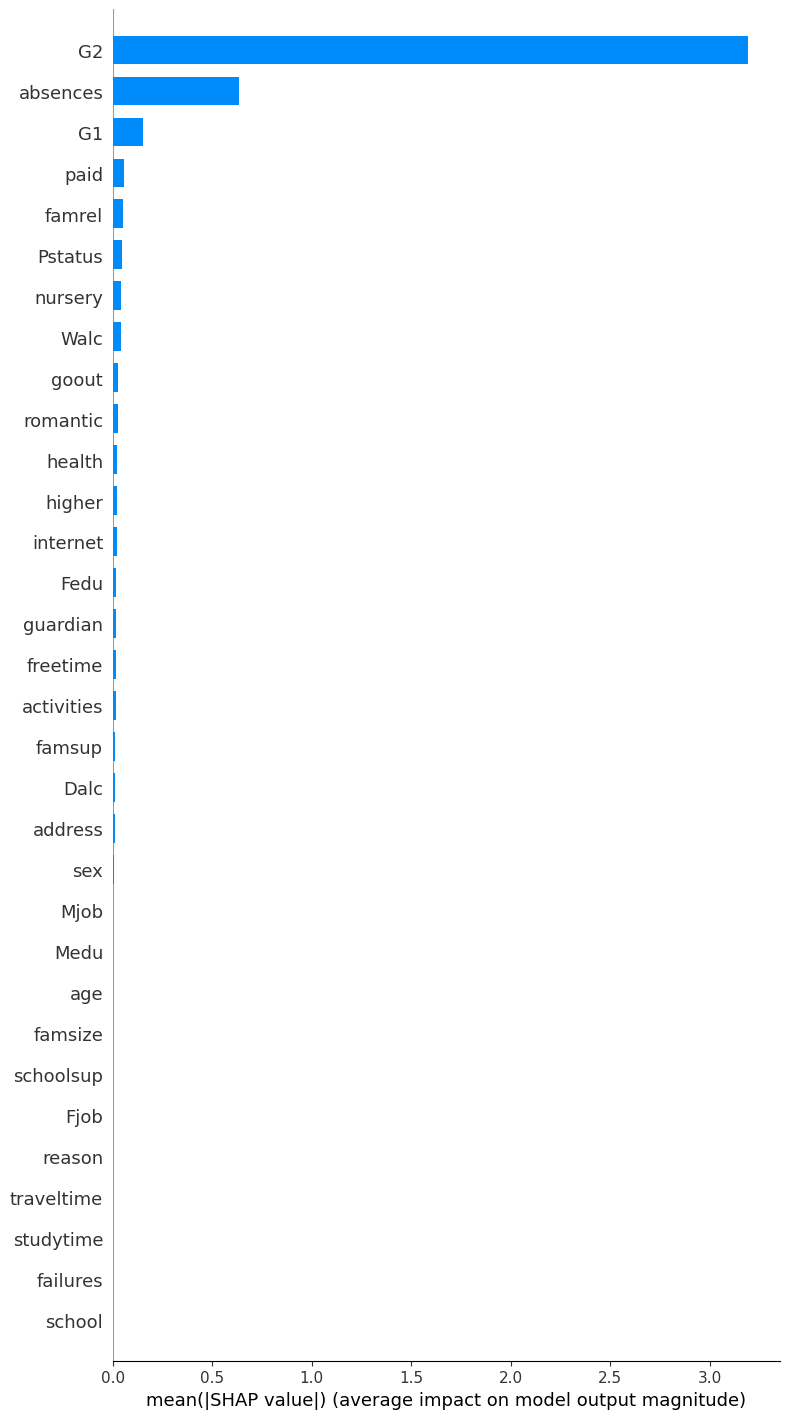

In [57]:
shap.summary_plot(shap_values, X_column, plot_type="bar", max_display=num_features)


STUDENT LOC: 1
Predicted Performance: 8.71
Actual Performance: 8


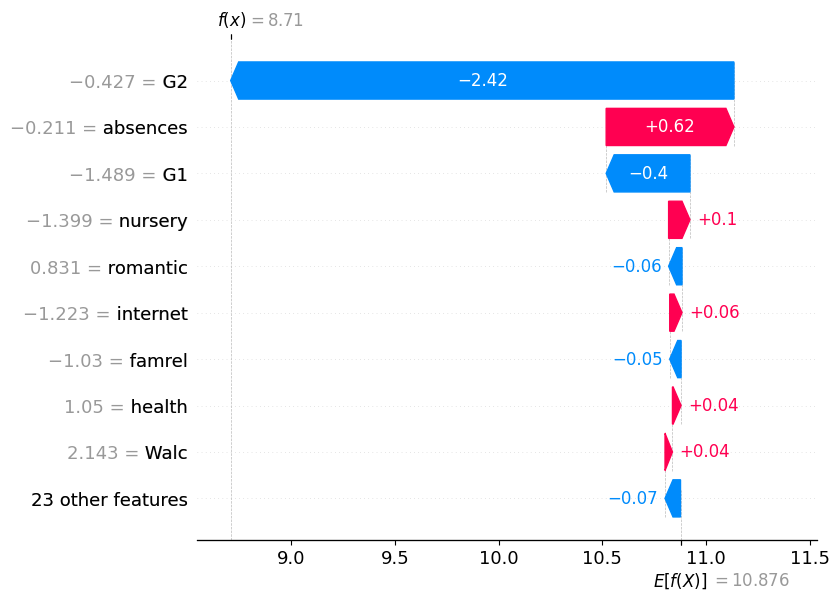


STUDENT LOC: 2
Predicted Performance: 13.15
Actual Performance: 13


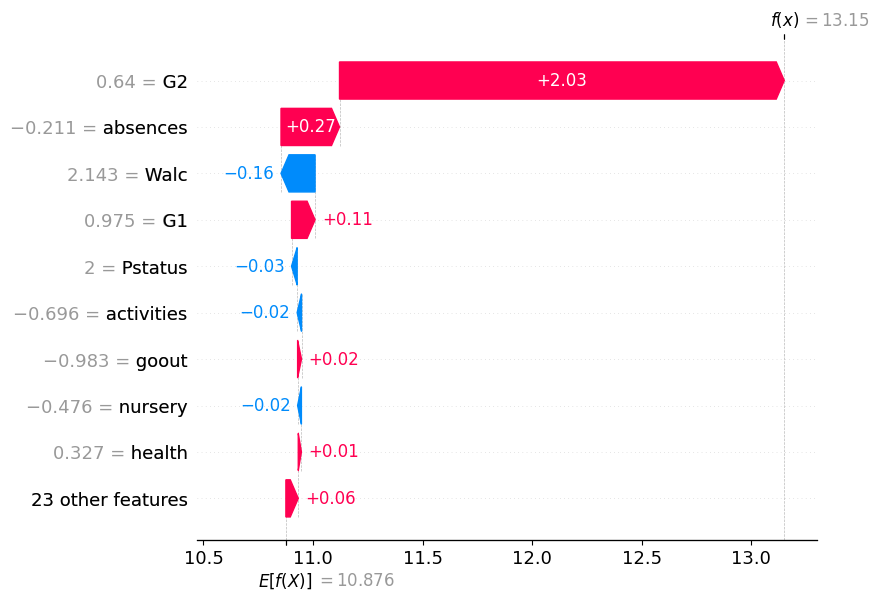


STUDENT LOC: 4
Predicted Performance: 1.16
Actual Performance: 0


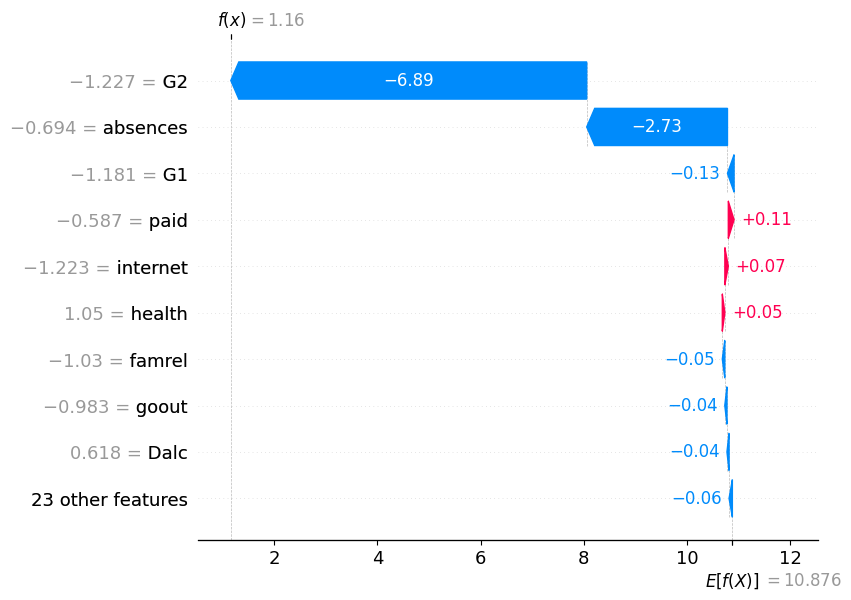

In [65]:
sv = explainer(X_column)
y_test_pred = model.predict(X_test)
y_test_df = y_test.to_frame()  # Convert y_test to DataFrame

for student_no in [0,1,3]:    
    print(f"\nSTUDENT LOC: {student_no+1}")
    print(f"Predicted Performance: {y_test_pred[student_no]}")
    print(f"Actual Performance: {y_test_df['G3'].iloc[student_no]}")  # Use iloc for DataFrame
    exp = shap.Explanation(sv.values[student_no,:], 
                      sv.base_values[student_no], 
                      data=X_column.values[student_no,:], 
                      feature_names=X_column.columns)

    shap.plots.waterfall(exp)

In [66]:
print(f"BEST MODEL: {best_model.name}")
print(best_model)

BEST MODEL: RandomForestRegressor
Adjusted R-Squared   0.87
R-Squared            0.92
RMSE                 1.34
Time Taken           0.33
Name: RandomForestRegressor, dtype: float64


### INSIGHTS

**Best Model based on LazyRegressor**

Random Forest Regressor \
&emsp;Adjusted R-Squared = 0.87 \
&emsp;R-Squared = 0.92 \
&emsp;RMSE = 1.34 \
&emsp;Time Taken = 0.33 \
Lower RMSE than the best performing model in the article for Mathematics data.

**What are SHAP (Shapley Additive exPlanations) values?**

&emsp;SHAP values are a game-theoretic approach to explain the output of any machine learning model by fairly allocating credit for the model's output prediction \( f_x \) among input features. Note that the magnitude of a SHAP value measures the contribution of a corresponding feature to the model's prediction, and the sign of a SHAP value signals whether the corresponding feature made a positive contribution (positive sign) or a negative contribution (negative sign). Adding all SHAP values to the base value or the average model prediction results in obtaining the model's output for an instance.

**Feature Importance Plot (Bar Chart)**

&emsp;The figure shows the mean absolute SHAP value, which is the average impact of each feature on the predictions for the final grade (G3) over all students. The most significant feature in predicting the final grade is the second-period grade (G2). This is followed by the number of absences, suggesting that higher absences negatively affect the final grade. The first-period grade (G1) is also essential but relatively less necessary than G2.

**Individual SHAP Value Plots**

&emsp;The figure is a collection of SHAP value plots for the feature values of a particular instance. A SHAP value plot shows the contribution of the feature values on the prediction of the final grade (G3) of a particular student. The base value is 10.876, and each plot is for a different student. Here are some observations for 3 students:

    Student 1:
    - G2 strongly negatively influences the predicted grade by -2.41.
    - Number of absences positively influence the grade by 0.63, meaning that the student may has lower number of absences.
    - G1 negatively influences the grade, but less than G2.
    - Predicted G3 is 8.71. True G3 is 8.

    Student 2:
    - G2 strongly positively influences the predicted grade by 2.03.
    - Number of absences has a positive impact of 0.27.
    - Weekend Alcohol Consumption (Walc) has a slight negative impact of -0.15. 
    - Predicted G3 is 13.15. True G3 is 13.
    
    Student 4:
    - G2 has a significant negative impact of -6.88.
    - Number of absences strongly negatively influences the predicted grade by -2.62.
    - G1 has a slight negative impact of -0.16.
    - Predicted G3 is 1.16. True G3 is 0.

&emsp;In summary, based on the SHAP values, the most important factors are grades from prior periods (G2, G1) and the number of absences, while other features have varying levels of influence depending on the particular student's data.